In [ ]:
!git clone
'''ben gimme that repo'''

In [ ]:
!pip install transformers; pip install wayback; pip install yfinance

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.1/41.1 kB 539.9 kB/s eta 0:00:00


In [2]:
import yfinance as yf
from wayback import WaybackClient
import gdown
import torch
import numpy as np
import transformers
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
# from keras.preprocessing.sequence import pad_sequences

from transformers import BertTokenizer
from transformers import get_linear_schedule_with_warmup
from transformers import BertForSequenceClassification, AdamW, BertConfig
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

%matplotlib inline

from bs4 import BeautifulSoup
from urllib.request import urlopen
from urllib.request import Request

# gdown.download('https://drive.google.com/uc?id=1q4U2gVY9tWEPdT6W-pdQpKmo152QqWLE', 'finance_train.csv', True)
# gdown.download('https://drive.google.com/uc?id=1nIBqAsItwVEGVayYTgvybz7HeK0asom0', 'finance_test.csv', True)

In [ ]:
!wget 'https://storage.googleapis.com/inspirit-ai-data-bucket-1/Data/AI%20Scholars/Sessions%206%20-%2010%20(Projects)/Project%20-%20NLP%2BFinance/finance_test.csv'
!wget 'https://storage.googleapis.com/inspirit-ai-data-bucket-1/Data/AI%20Scholars/Sessions%206%20-%2010%20(Projects)/Project%20-%20NLP%2BFinance/finance_train.csv'

n = 20 #the # of article headlines displayed per ticker
tickers = ['AAPL', 'TSLA', 'AMZN']

def get_finance_train():
  df_train = pd.read_csv("finance_train.csv")
  return df_train
def get_finance_test():
  df_test = pd.read_csv("finance_test.csv")
  return df_test


def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

print ("Train and Test Files Loaded as train.csv and test.csv")

LABEL_MAP = {0 : "negative", 1 : "neutral", 2 : "positive"}
NONE = 4 * [None]
RND_SEED=2020

In [9]:
msft = yf.Ticker("TSLA")

In [10]:
hist = msft.history(period="10y")

In [11]:
msft.history_metadata

{'currency': 'USD',
 'symbol': 'TSLA',
 'exchangeName': 'NMS',
 'fullExchangeName': 'NasdaqGS',
 'instrumentType': 'EQUITY',
 'firstTradeDate': 1277818200,
 'regularMarketTime': 1715264724,
 'hasPrePostMarketData': True,
 'gmtoffset': -14400,
 'timezone': 'EDT',
 'exchangeTimezoneName': 'America/New_York',
 'regularMarketPrice': 173.74,
 'fiftyTwoWeekHigh': 175.62,
 'fiftyTwoWeekLow': 173.15,
 'regularMarketDayHigh': 175.62,
 'regularMarketDayLow': 173.15,
 'regularMarketVolume': 16286253,
 'chartPreviousClose': 12.151,
 'priceHint': 2,
 'currentTradingPeriod': {'pre': {'timezone': 'EDT',
   'start': 1715241600,
   'end': 1715261400,
   'gmtoffset': -14400},
  'regular': {'timezone': 'EDT',
   'start': 1715261400,
   'end': 1715284800,
   'gmtoffset': -14400},
  'post': {'timezone': 'EDT',
   'start': 1715284800,
   'end': 1715299200,
   'gmtoffset': -14400}},
 'dataGranularity': '1d',
 'range': '10y',
 'validRanges': ['1d',
  '5d',
  '1mo',
  '3mo',
  '6mo',
  '1y',
  '2y',
  '5y',
  

In [12]:
print(type(hist))

<class 'pandas.core.frame.DataFrame'>


In [13]:
# send hist to csv
hist.to_csv("msft.csv") # randomly select from the days here and use this for webscrape

## Webscrape

In [ ]:
finviz_url = 'https://finviz.com/quote.ashx?t='
news_tables = {}

for ticker in tickers:
    url = finviz_url + ticker
    req = Request(url=url,headers={'user-agent': 'FireFox'})
    resp = urlopen(req)
    html = BeautifulSoup(resp, features="lxml")
    news_table = html.find(id='news-table')
    news_tables[ticker] = news_table

try:
    for ticker in tickers:
        df = news_tables[ticker]
        df_tr = df.findAll('tr')


        for i, table_row in enumerate(df_tr):
            # print("table row", table_row)
            try:
              a_text = table_row.a.text
            except:
              continue
            td_text = table_row.td.text
            td_text = td_text.strip()
            if i == n-1:
                break
except KeyError:
    pass

parsed_news = []
for file_name, news_table in news_tables.items():
    for x in news_table.findAll('tr'):
        try:
          text = x.a.get_text()
        except:
          continue
        date_scrape = x.td.text.split()

        if len(date_scrape) == 1:
            time = date_scrape[0]

        else:
            date = date_scrape[0]
            time = date_scrape[1]

        ticker = file_name.split('_')[0]

        parsed_news.append([ticker, date, time, text])

columns = ['Ticker', 'Date', 'Time', 'Headline']
news = pd.DataFrame(parsed_news, columns=columns)
print(news)

    Ticker       Date     Time  \
0     AAPL      Today  04:29PM   
1     AAPL      Today  04:12PM   
2     AAPL      Today  03:56PM   
3     AAPL      Today  03:51PM   
4     AAPL      Today  03:46PM   
..     ...        ...      ...   
295   AMZN  May-01-24  07:42AM   
296   AMZN  May-01-24  07:35AM   
297   AMZN  May-01-24  07:30AM   
298   AMZN  May-01-24  07:30AM   
299   AMZN  May-01-24  07:25AM   

                                              Headline  
0    Apple: Here's why Morgan Stanley's Erik Woodri...  
1    Stocks jump after April jobs data, Apple buyba...  
2    Apple bulls raise price targets after buyback ...  
3    Hudson Pacific Properties, Inc. (NYSE:HPP) Q1 ...  
4    These Stocks Are Moving the Most Today: Apple,...  
..                                                 ...  
295  Monness Crespi Hardt Raises Amazon's Price Tar...  
296  Seaport Global Securities Adjusts Amazon Price...  
297  Amazon jumps on earnings, Fed decision nears: ...  
298  Amazon Stock Ear

## Tokenize stuff

In [ ]:
# TODO: make class to handle tokenization
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased", do_lower_case = True)

class CustomTokenizer:
  def __init__(self, tokenizer):
    self.tokenizer = tokenizer
    self.do_lower_case = True

  def tokenize(self,sentences):
    # print(df["Sentence"].values)
    # labels = df["Label"].values
    sentences_with_special_tokens = []
    tokenized_texts = []
    input_ids = []
    attention_masks = []


    for sentence in sentences:
      sentence = "[CLS] " + sentence + " [SEP]" # add beginning & ending tokens
      sentences_with_special_tokens.append(sentence)

    for sentence in sentences_with_special_tokens:
      sentence = self.tokenizer.tokenize(sentence)
      tokenized_texts.append(sentence)

    for sentence in tokenized_texts:
      sentence = self.tokenizer.convert_tokens_to_ids(sentence)
      input_ids.append(sentence)

    input_ids = pad_sequences(input_ids,
                          maxlen=128,
                          dtype="long",
                          truncating="post",
                          padding="post")

    for sentence in input_ids:
      sentence = [float(i>0) for i in sentence]
      attention_masks.append(sentence)

    return input_ids, attention_masks



"""
outputs = model(b_input_ids,
                                   token_type_ids=None,
                                   attention_mask=b_input_mask,
                                   labels=b_labels)
# self.df = get_finance_train()
# df_test = get_finance_test()
"""

'\noutputs = model(b_input_ids,\n                                   token_type_ids=None,\n                                   attention_mask=b_input_mask,\n                                   labels=b_labels)\n# self.df = get_finance_train()\n# df_test = get_finance_test()\n'

In [ ]:
df_train = pd.read_csv('finance_train.csv')
df_test = pd.read_csv('finance_test.csv')

custom_tokenizer = CustomTokenizer(BertTokenizer.from_pretrained("bert-base-uncased", do_lower_case = True))
input_ids, attention_masks = custom_tokenizer.tokenize(df_train['Sentence'].values) # TODO: accuracy score by category
labels = df_train['Label'].values

In [ ]:
outputs = model(input_ids,
                                   token_type_ids=None,
                                   attention_mask=attention_masks,
                                   labels=b_labels)
loss = outputs[0]
logits = outputs[1]

## Splits, Model Initialization

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(input_ids, labels, test_size = 0.15, random_state=RND_SEED)
train_masks, validation_masks, _, _ = train_test_split(attention_masks, input_ids, test_size = 0.15, random_state=RND_SEED)
train_inputs = torch.tensor(np.array(X_train));
validation_inputs = torch.tensor(np.array(X_val));
train_masks = torch.tensor(np.array(train_masks));
validation_masks = torch.tensor(np.array(validation_masks));
train_labels = torch.tensor(np.array(y_train));
validation_labels = torch.tensor(np.array(y_val));

batch_size = 32
train_data = TensorDataset(train_inputs, train_masks, train_labels);
train_sampler = RandomSampler(train_data);
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size);
validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels);
validation_sampler = SequentialSampler(validation_data);
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size);

# Consider using roberta if base bert isn't good enough
model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased",
    num_labels = 3,
    output_attentions = False,
    output_hidden_states = False,
);


model.cuda();

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_gpu = torch.cuda.device_count()
torch.cuda.get_device_name(0)
optimizer = AdamW(model.parameters(),
                  lr = 2e-5,
                  eps = 1e-8
                )
epochs = 4

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:521: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


## Train Loop

In [ ]:
from tqdm import tqdm
total_steps = len(train_dataloader) * epochs

scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)

training_loss = []
validation_loss = []
training_stats = []

np.random.seed(RND_SEED)
torch.manual_seed(RND_SEED)
torch.cuda.manual_seed_all(RND_SEED)

for epoch_i in range(0, epochs):
    print('Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training the model')
    total_train_loss = 0
    model.train()
    for step, batch in tqdm(enumerate(train_dataloader)):
        if step % 20 == 0 and not step == 0:
            print('  Batch {:>5,}  of  {:>5,}. '.format(step, len(train_dataloader)))

        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        model.zero_grad()

        outputs = model(b_input_ids,
                             token_type_ids=None,
                             attention_mask=b_input_mask,
                             labels=b_labels)
        loss = outputs[0]
        logits = outputs[1]

        total_train_loss += loss.item()

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        optimizer.step()
        scheduler.step()

    avg_train_loss = total_train_loss / len(train_dataloader)

    print("  Average training loss: {0:.2f}".format(avg_train_loss))


    print("Evaluating on Validation Set")
    model.eval()
    total_eval_accuracy = 0
    total_eval_loss = 0
    nb_eval_steps = 0
    for batch in validation_dataloader:

        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        with torch.no_grad():

            outputs = model(b_input_ids,
                                   token_type_ids=None,
                                   attention_mask=b_input_mask,
                                   labels=b_labels)
            loss = outputs[0]
            logits = outputs[1]

        total_eval_loss += loss.item()

        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()


        total_eval_accuracy += flat_accuracy(logits, label_ids)


    avg_val_accuracy = total_eval_accuracy / len(validation_dataloader)
    print("Validation Accuracy: {0:.2f}".format(avg_val_accuracy))

    avg_val_loss = total_eval_loss / len(validation_dataloader)

    print("Validation Loss: {0:.2f}".format(avg_val_loss))


    training_loss.append(avg_train_loss)
    validation_loss.append(avg_val_loss)

    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Valid. Accur.': avg_val_accuracy

        }
    )

print("Training complete!")

Epoch 1 / 4 ========
Training the model


20it [00:13,  1.68it/s]

  Batch    20  of     55. 


40it [00:26,  1.63it/s]

  Batch    40  of     55. 


55it [00:34,  1.57it/s]


  Average training loss: 0.63
Evaluating on Validation Set
Validation Accuracy: 0.80
Validation Loss: 0.43
Epoch 2 / 4 ========
Training the model


20it [00:12,  1.55it/s]

  Batch    20  of     55. 


40it [00:26,  1.49it/s]

  Batch    40  of     55. 


55it [00:35,  1.54it/s]


  Average training loss: 0.35
Evaluating on Validation Set
Validation Accuracy: 0.83
Validation Loss: 0.32
Epoch 3 / 4 ========
Training the model


20it [00:13,  1.50it/s]

  Batch    20  of     55. 


40it [00:26,  1.53it/s]

  Batch    40  of     55. 


55it [00:35,  1.53it/s]


  Average training loss: 0.20
Evaluating on Validation Set
Validation Accuracy: 0.95
Validation Loss: 0.17
Epoch 4 / 4 ========
Training the model


20it [00:12,  1.54it/s]

  Batch    20  of     55. 


40it [00:25,  1.53it/s]

  Batch    40  of     55. 


55it [00:35,  1.56it/s]


  Average training loss: 0.10
Evaluating on Validation Set
Validation Accuracy: 0.95
Validation Loss: 0.16
Training complete!


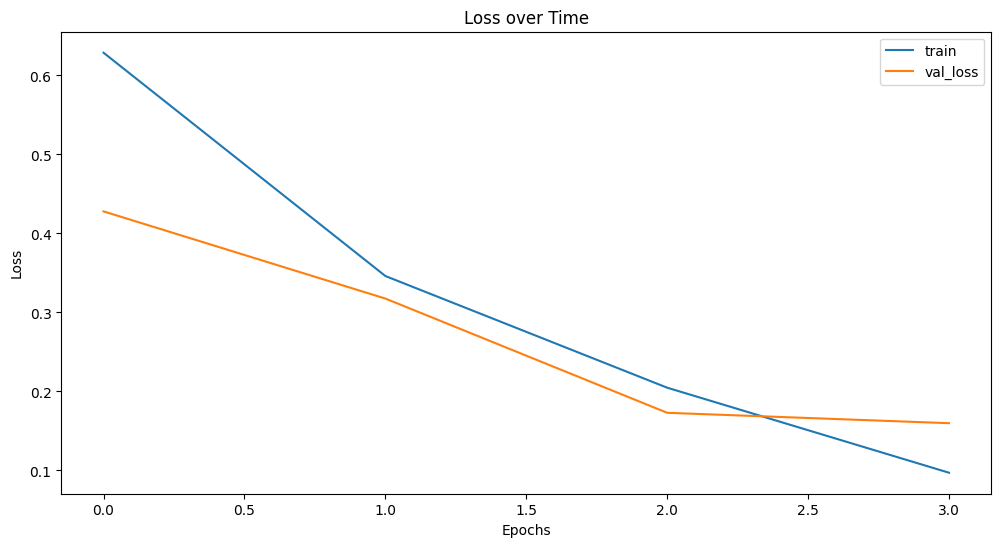

In [ ]:
fig = plt.figure(figsize=(12,6))
plt.title('Loss over Time')
plt.xlabel('Epochs')
plt.ylabel('Loss')

plt.plot(training_loss, label = "train")
plt.plot(validation_loss, label = "val_loss")

plt.legend()
plt.show()
test_sentences = df_test["Sentence"].values
test_labels = df_test["Label"].values

In [ ]:
test_input_ids, test_attention_masks = [], []

test_sentences = ["[CLS] " + sentence + " [SEP]" for sentence in test_sentences]

tokenized_test_sentences = [tokenizer.tokenize(sent) for sent in test_sentences]

test_input_ids = [tokenizer.convert_tokens_to_ids(txt) for txt in tokenized_test_sentences]

test_input_ids = pad_sequences(test_input_ids,
                               maxlen=128,
                               dtype="long",
                               truncating="post",
                               padding="post")

for sequence in test_input_ids:
  mask = [float(i>0) for i in sequence]
  test_attention_masks.append(mask)

In [ ]:
batch_size = 32
test_input_ids = torch.tensor(test_input_ids)
test_attention_masks = torch.tensor(test_attention_masks)
test_labels = torch.tensor(test_labels)
prediction_data = TensorDataset(test_input_ids, test_attention_masks, test_labels)
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)

<ipython-input-84-c7ec7857efdc>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  test_labels = torch.tensor(test_labels)


In [ ]:

print('Predicting labels for {:,} test sentences...'.format(len(test_input_ids)))

model.eval()

predictions , true_labels = [], []

for batch in prediction_dataloader:
  batch = tuple(t.to(device) for t in batch)
  b_input_ids, b_input_mask, b_labels = batch

  with torch.no_grad():
      outputs = model(b_input_ids, token_type_ids=None,
                      attention_mask=b_input_mask)

  logits = outputs[0]

  logits = logits.detach().cpu().numpy()
  label_ids = b_labels.to('cpu').numpy()

  predictions.append(torch.softmax(torch.from_numpy(logits), dim=1))
  true_labels.append(label_ids)


from sklearn.metrics import accuracy_score
# flat_predictions = [item for sublist in predictions for item in sublist]
# flat_predictions = np.argmax(flat_predictions, axis=1).flatten()

# print(" sigmoided accuracy {:.2%}".format(accuracy_score(label_ids, , *, normalize=True, sample_weight=None)))


Predicting labels for 227 test sentences...


In [ ]:
print(len(test_sentences))
print(len(test_labels))
print(len(predictions))

227
227
8


In [ ]:
idx = 0
for batch_prediction in predictions:
  for prediction in batch_prediction:
    print(prediction)
    t = LABEL_MAP[torch.argmax(prediction).item()]
    print(prediction, "main prediction",t, "label for sentence", LABEL_MAP[test_labels[idx].item()], " predicted for sentence: ", test_sentences[idx])
    idx += 1

tensor([0.0637, 0.0182, 0.9181])
tensor([0.0637, 0.0182, 0.9181]) main prediction positive label for sentence positive  predicted for sentence:  [CLS] [CLS] [CLS] In the third quarter of 2010 , net sales increased by 5.2 % to EUR 205.5 mn , and operating profit by 34.9 % to EUR 23.5 mn . [SEP] [SEP] [SEP]
tensor([0.0681, 0.0179, 0.9140])
tensor([0.0681, 0.0179, 0.9140]) main prediction positive label for sentence positive  predicted for sentence:  [CLS] [CLS] [CLS] Foundries division reports its sales increased by 9.7 % to EUR 63.1 mn from EUR 57.5 mn in the corresponding period in 2006 , and sales of the Machine Shop division increased by 16.4 % to EUR 41.2 mn from EUR 35.4 mn in the corresponding period in 2006 . [SEP] [SEP] [SEP]
tensor([0.0034, 0.9887, 0.0079])
tensor([0.0034, 0.9887, 0.0079]) main prediction neutral label for sentence neutral  predicted for sentence:  [CLS] [CLS] [CLS] Financing of the project will come mainly from China . [SEP] [SEP] [SEP]
tensor([0.0069, 0.9836,

In [ ]:
real_input_ids, real_attention_masks = [], []

real_sentences = ["[CLS] " + sentence + " [SEP]" for sentence in news["Headline"]]

tokenized_real_sentences = [tokenizer.tokenize(sent) for sent in real_sentences]

real_input_ids = [tokenizer.convert_tokens_to_ids(txt) for txt in tokenized_real_sentences]

real_input_ids = pad_sequences(real_input_ids,
                               maxlen=128,
                               dtype="long",
                               truncating="post",
                               padding="post")

for sequence in real_input_ids:
  mask = [float(i>0) for i in sequence]
  real_attention_masks.append(mask)

In [ ]:
batch_size = 32
real_input_ids = torch.tensor(real_input_ids)
real_attention_masks = torch.tensor(real_attention_masks)
prediction_data = TensorDataset(real_input_ids, real_attention_masks)
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)

In [ ]:
predictions = []

for batch in prediction_dataloader:
  batch = tuple(t.to(device) for t in batch)
  b_input_ids, b_input_mask = batch

  with torch.no_grad():
      outputs = model(b_input_ids, token_type_ids=None,
                      attention_mask=b_input_mask)

  logits = outputs[0]

  logits = logits.detach().cpu().numpy()
  # label_ids = b_labels.to('cpu').numpy()

  for logit in logits:
    # print(logit.shape)
    softmaxxed = torch.softmax(torch.from_numpy(logit), dim=0)
    # print(softmaxxed, torch.argmax(softmaxxed, dim=0))
    final_arr = torch.concatenate((softmaxxed, torch.argmax(softmaxxed, dim=0).unsqueeze(0)))
    predictions.append(final_arr)

print("predictions")

df_scores = pd.DataFrame(np.array(predictions))
news_joined = news.join(df_scores.rename(columns={**LABEL_MAP, 3: "Sentiment"}), rsuffix='_right')

# in the Sentiment column, assign each to label map
news_joined['Sentiment'] = news_joined['Sentiment'].map(LABEL_MAP)

predictions


In [ ]:
news_joined

,Ticker,Date,Time,Headline,negative,neutral,positive,Sentiment
0,AAPL,Today,04:29PM,Apple: Here's why Morgan Stanley's Erik Woodri...,0.018430,0.959906,0.021664,neutral
1,AAPL,Today,04:12PM,"Stocks jump after April jobs data, Apple buyba...",0.054879,0.915280,0.029841,neutral
2,AAPL,Today,03:56PM,Apple bulls raise price targets after buyback ...,0.010485,0.942235,0.047280,neutral
3,AAPL,Today,03:51PM,"Hudson Pacific Properties, Inc. (NYSE:HPP) Q1 ...",0.003686,0.986946,0.009368,neutral
4,AAPL,Today,03:46PM,"These Stocks Are Moving the Most Today: Apple,...",0.006838,0.971291,0.021871,neutral
...,...,...,...,...,...,...,...,...
295,AMZN,May-01-24,07:42AM,Monness Crespi Hardt Raises Amazon's Price Tar...,0.033010,0.047273,0.919717,positive
296,AMZN,May-01-24,07:35AM,Seaport Global Securities Adjusts Amazon Price...,0.004189,0.967357,0.028454,neutral
297,AMZN,May-01-24,07:30AM,"Amazon jumps on earnings, Fed decision nears: ...",0.006771,0.964300,0.028929,neutral
298,AMZN,May-01-24,07:30AM,Amazon Stock Earnings: The Path to $1 Trillion...,0.004480,0.977552,0.017968,neutral


In [ ]:
# Using dataframe news_joined: show number of negative, positive, neutral sentiments. print by ticker

news_joined.groupby('Ticker').agg(
    negative_count=('negative', 'sum'),
    positive_count=('positive', 'sum'),
    neutral_count=('neutral', 'sum')
)


,negative_count,positive_count,neutral_count
Ticker,,,
AAPL,11.613146,21.856199,66.530655
AMZN,6.705750,19.593880,73.700371
TSLA,10.611959,14.942500,74.445541


In [ ]:
# print number of positive, negatives in news_joined
print(news_joined['negative'].value_counts())
print(news_joined['neutral'].value_counts())
print(news_joined['positive'].value_counts())


negative
0.029937    3
0.007156    2
0.006514    2
0.020717    2
0.007539    2
           ..
0.004932    1
0.003383    1
0.163616    1
0.041505    1
0.009235    1
Name: count, Length: 288, dtype: int64
neutral
0.981643    3
0.187607    3
0.915057    2
0.931849    2
0.979348    2
           ..
0.984201    1
0.988623    1
0.054766    1
0.630656    1
0.951950    1
Name: count, Length: 287, dtype: int64
positive
0.782455    3
0.013497    2
0.012541    2
0.047434    2
0.009520    2
           ..
0.010867    1
0.007994    1
0.781618    1
0.327838    1
0.038815    1
Name: count, Length: 288, dtype: int64


In [ ]:
news['Date'] = pd.to_datetime(news.Date).dt.date

unique_ticker = news['Ticker'].unique().tolist()
news_dict = {name: news.loc[news['Ticker'] == name] for name in unique_ticker}

values = []
for ticker in tickers:
    dataframe = news_dict[ticker]
    dataframe = dataframe.set_index('Ticker')
    dataframe = dataframe.drop(columns = ['Headline'])
    print ('\n')
    print (dataframe.head())

    mean = round(dataframe['compound'].mean(), 2)
    values.append(mean)

df = pd.DataFrame(list(zip(tickers, values)), columns =['Ticker', 'Mean Sentiment'])
df = df.set_index('Ticker')
df = df.sort_values('Mean Sentiment', ascending=False)
print ('\n')
print (df)